## **Identifying Key Contributors to Road Traffic Accidents Using XGBoost and Exploratory Data Analysis**
### Objectives
* To explore and analyze road traffic crash data to understand patterns and trends in accidents.
* To develop a predictive machine learning model to classify accident severity.
* To evaluate the performance of the predictive model using appropriate metrics such as accuracy, precision, recall and F1-score.
* To provide data-driven recommendations for improving road safety and reducing accident severity.

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid', {'axes.facecolor':'0.9'})
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

In [2]:
crashes=pd.read_csv('./data/Traffic_Crashes_-_Crashes.csv.gz', low_memory=False)
people=pd.read_csv('./data/Traffic_Crashes_-_People.csv.gz', low_memory=False)
vehicles=pd.read_csv('./data/Traffic_Crashes_-_Vehicles.csv.gz', low_memory=False)

In [3]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                54959 non-null  object 
 1   CRASH_DATE_EST_I               3503 non-null   object 
 2   CRASH_DATE                     54959 non-null  object 
 3   POSTED_SPEED_LIMIT             54959 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         54959 non-null  object 
 5   DEVICE_CONDITION               54959 non-null  object 
 6   WEATHER_CONDITION              54959 non-null  object 
 7   LIGHTING_CONDITION             54959 non-null  object 
 8   FIRST_CRASH_TYPE               54959 non-null  object 
 9   TRAFFICWAY_TYPE                54959 non-null  object 
 10  LANE_CNT                       6 non-null      float64
 11  ALIGNMENT                      54959 non-null  object 
 12  ROADWAY_SURFACE_COND           54959 non-null 

In [4]:
crashes.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 

In [5]:
crashes.CRASH_RECORD_ID.duplicated().sum()

0

In [6]:
crashes.MOST_SEVERE_INJURY.value_counts()

NO INDICATION OF INJURY     45514
NONINCAPACITATING INJURY     4982
REPORTED, NOT EVIDENT        3502
INCAPACITATING INJURY         809
FATAL                          47
Name: MOST_SEVERE_INJURY, dtype: int64

In [7]:
crashes['IS_SEVERE'] = (
    (crashes['INJURIES_INCAPACITATING'] > 0) |
    (crashes['INJURIES_FATAL'] > 0)
)

In [8]:
crashes.ROADWAY_SURFACE_COND.value_counts()

DRY                40314
UNKNOWN             7662
WET                 4588
SNOW OR SLUSH       1937
ICE                  271
OTHER                175
SAND, MUD, DIRT       12
Name: ROADWAY_SURFACE_COND, dtype: int64

In [9]:
crashes['ROADWAY_SURFACE_COND'].replace(['SAND, MUD, DIRT', 'OTHER'], 'OTHER_RARE', inplace=True)

In [10]:
crashes.WEATHER_CONDITION.value_counts()

CLEAR                       44097
UNKNOWN                      4525
RAIN                         2825
SNOW                         1751
CLOUDY/OVERCAST              1379
OTHER                         200
FREEZING RAIN/DRIZZLE          74
BLOWING SNOW                   42
SLEET/HAIL                     40
FOG/SMOKE/HAZE                 22
SEVERE CROSS WIND GATE          3
BLOWING SAND, SOIL, DIRT        1
Name: WEATHER_CONDITION, dtype: int64

In [11]:
crashes['WEATHER_CONDITION'].replace(['BLOWING SAND, SOIL, DIRT', 'OTHER'], 'OTHER_RARE', inplace=True)

In [12]:
crashes.groupby('ROADWAY_SURFACE_COND')['IS_SEVERE'].mean().sort_values(ascending=False)

ROADWAY_SURFACE_COND
WET              0.022886
DRY              0.016892
SNOW OR SLUSH    0.011874
OTHER_RARE       0.010695
ICE              0.007380
UNKNOWN          0.005612
Name: IS_SEVERE, dtype: float64

## In wet roadway surface the rate of injury severity is highest.

In [13]:
crashes['SPEED_BIN'] = pd.cut(
    crashes['POSTED_SPEED_LIMIT'],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=['≤25', '30-35', '40-45', '50-55', '60-65', '65+'],
    include_lowest=True)

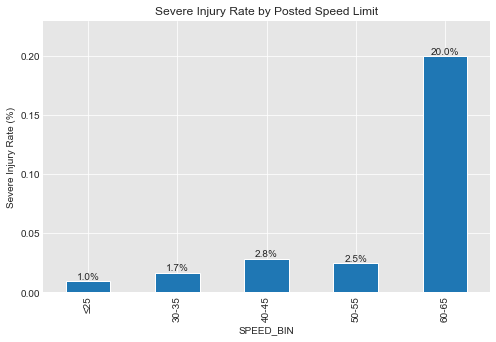

In [14]:
rates = crashes.groupby('SPEED_BIN')['IS_SEVERE'].mean()
rates = rates.dropna()
ax = rates.plot(kind='bar', figsize=(8,5))
plt.ylabel('Severe Injury Rate (%)')
plt.title('Severe Injury Rate by Posted Speed Limit')
plt.ylim(0, rates.max() * 1.15)
for i, rate in enumerate(rates):
    ax.text(
        i,
        rate,
        f"{rate:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

### The percentages represent the probability of a severe injury given a specific posted speed limit category. The likelihood of severe injuries in speed limits ranging from 60-65km/h is 20%.

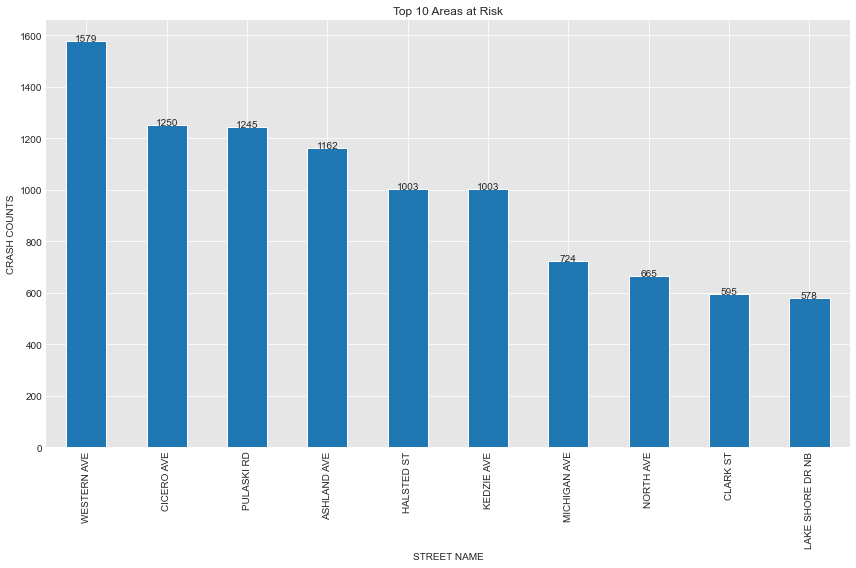

In [15]:
# top 10 areas at risk
top_10_risk_areas = crashes.STREET_NAME.value_counts().head(10)
top_10_risk_areas.plot(kind='bar', figsize=(12,8))
plt.title('Top 10 Areas at Risk')
plt.ylabel('CRASH COUNTS')
plt.xlabel('STREET NAME')
for i, rate in enumerate(top_10_risk_areas):
    plt.text(i, rate, s=f'{rate}', ha='center', fontsize=10)
plt.tight_layout();

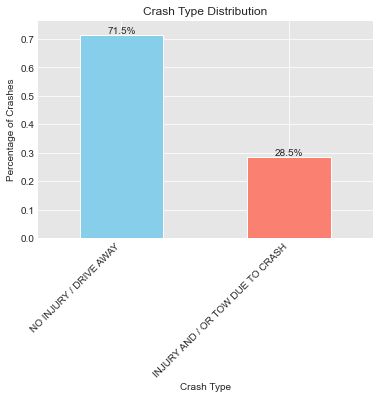

In [16]:
crash_type = crashes['CRASH_TYPE'].value_counts(normalize=True)
# Bar plot
crash_type.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Crash Type Distribution')
plt.xlabel('Crash Type')
plt.ylabel('Percentage of Crashes')
plt.ylim(0, crash_type.max() + 0.05)
plt.xticks(rotation=45, ha='right')
for i, rate in enumerate(crash_type):
    plt.text(
        i,
        rate + 0.005,
        f"{rate:.1%}",
        ha='center',
        fontsize=10
    );

## Analyzing primary contributing causes

In [17]:
crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10)

UNABLE TO DETERMINE                       22702
FAILING TO YIELD RIGHT-OF-WAY              6533
FOLLOWING TOO CLOSELY                      4989
IMPROPER OVERTAKING/PASSING                3034
NOT APPLICABLE                             2457
FAILING TO REDUCE SPEED TO AVOID CRASH     2269
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE        2189
IMPROPER TURNING/NO SIGNAL                 1899
IMPROPER LANE USAGE                        1833
IMPROPER BACKING                           1703
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64

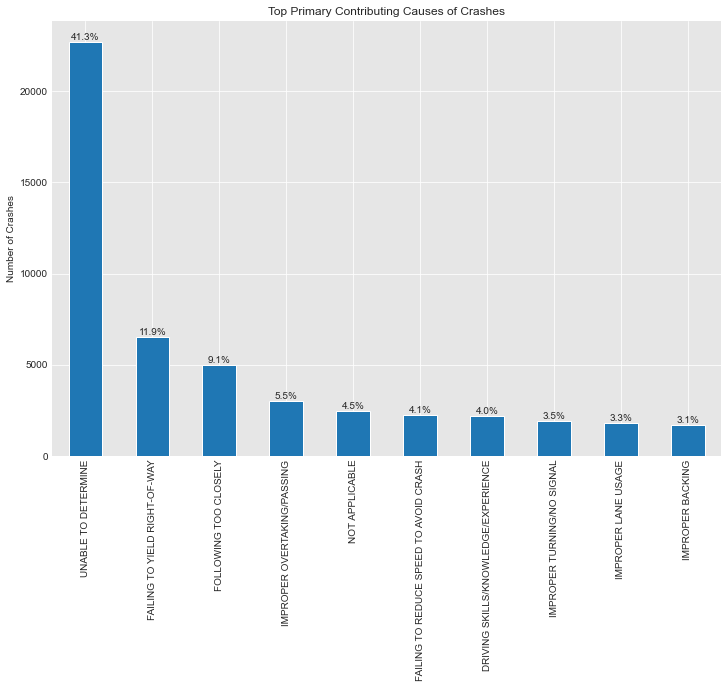

In [18]:
# Plot of top primary contributing causes of crashes
crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.title("Top Primary Contributing Causes of Crashes")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=90)
total = crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().sum()
for i, rate in enumerate(crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

## Time-Based Analysis

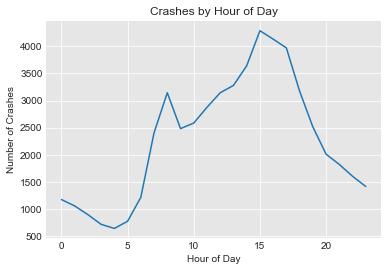

In [19]:
# Crash By Hour Plot
crashes['CRASH_HOUR'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crashes')
plt.title("Crashes by Hour of Day");

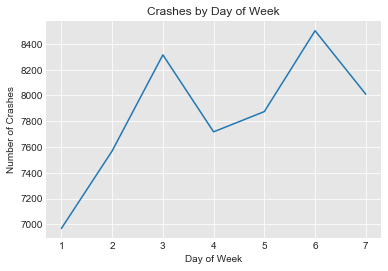

In [20]:
# Crashes By Day of Week Plot
crashes['CRASH_DAY_OF_WEEK'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Day of Week')
plt.ylabel('Number of Crashes')
plt.title("Crashes by Day of Week");

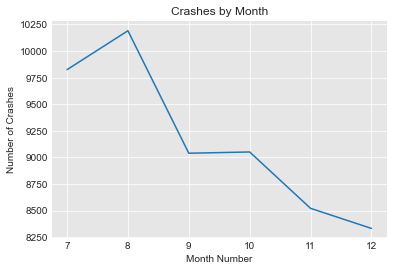

In [21]:
# Crash distribution monthly
crashes['CRASH_MONTH'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Month Number')
plt.ylabel('Number of Crashes')
plt.title("Crashes by Month");

## Statistical Tests

H<sub>0</sub>: Weather condition does not affect injuries VS
H<sub>1</sub>: Weather affects injuries at 1% level of significance

In [22]:
groups = [
    crashes[crashes['WEATHER_CONDITION'] == w]['INJURIES_TOTAL'].dropna()
    for w in crashes['WEATHER_CONDITION'].unique()
]
f_oneway(*groups)

F_onewayResult(statistic=36.390952708299125, pvalue=7.888266197739882e-72)

## Weather significantly affects the number of injuries.

H<sub>0</sub>: Lighting condition does not affect injuries VS
H<sub>1</sub>: Lighting affects injuries at 1% level of significance

In [23]:
groups = [
    crashes[crashes['LIGHTING_CONDITION'] == w]['INJURIES_TOTAL'].dropna()
    for w in crashes['LIGHTING_CONDITION'].unique()
]
f_oneway(*groups)

F_onewayResult(statistic=88.11142785500279, pvalue=1.2734770215895415e-92)

## Lighting condition affects the number of injuries at 1% level of significance.

In [24]:
crashes=crashes[['CRASH_RECORD_ID','WEATHER_CONDITION','LIGHTING_CONDITION','CRASH_TYPE','CRASH_HOUR','CRASH_MONTH','NUM_UNITS', 'ROADWAY_SURFACE_COND', 'POSTED_SPEED_LIMIT', 'IS_SEVERE']]

In [25]:
vehicles.columns

Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER',
       'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY',
       'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I',
       'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I',
       'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',
       'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO',
       'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE',
       'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO',
       'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I',
       'TRAILER1_

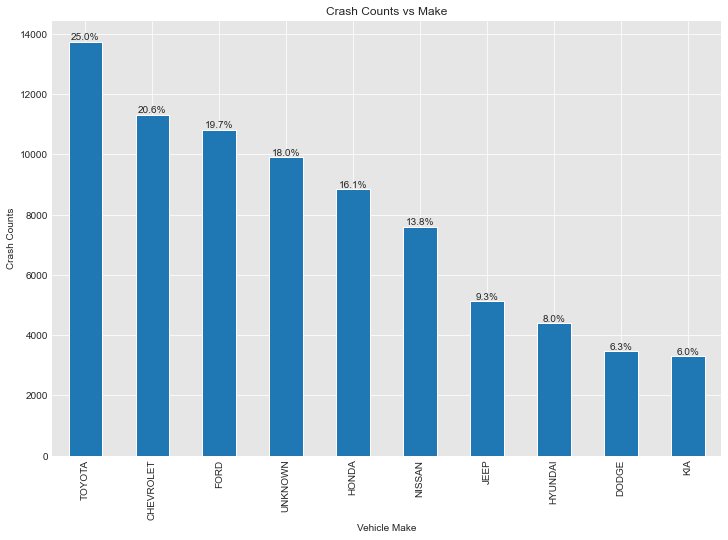

In [26]:
# Plot of Vehicle Make against their number of appearances in crashes.
vehicles.MAKE.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Vehicle Make')
plt.ylabel('Crash Counts')
plt.title('Crash Counts vs Make')
for i, rate in enumerate(vehicles.MAKE.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [27]:
people.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

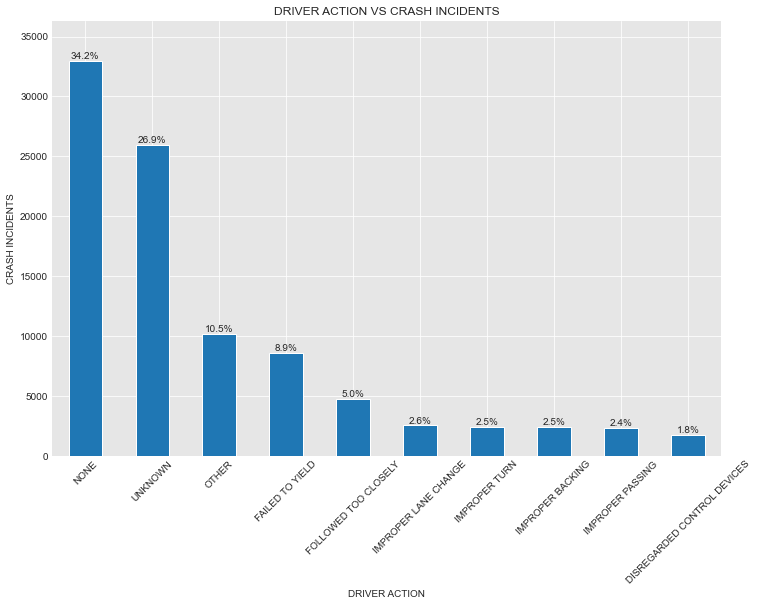

In [28]:
# Plot of Driver Action Count.
people.DRIVER_ACTION.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.title('DRIVER ACTION VS CRASH INCIDENTS')
plt.xlabel('DRIVER ACTION')
plt.ylabel('CRASH INCIDENTS')
plt.xticks(rotation=45)
plt.ylim(0, people.DRIVER_ACTION.value_counts().max() * 1.1)
total = people.DRIVER_ACTION.value_counts().sum()
for i, rate in enumerate(people.DRIVER_ACTION.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [29]:
vehicle_agg = vehicles.groupby('CRASH_RECORD_ID').agg({
    'OCCUPANT_CNT': 'sum'
}).reset_index()

In [30]:
vehicle_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CRASH_RECORD_ID  54959 non-null  object 
 1   OCCUPANT_CNT     54959 non-null  float64
dtypes: float64(1), object(1)
memory usage: 858.9+ KB


In [31]:
people_agg = people.groupby('CRASH_RECORD_ID').agg({
    'AGE': 'mean',
    'SAFETY_EQUIPMENT': lambda x: ((x == 'SAFETY BELT USED') | 
                                   (x == 'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)') |
                                   (x == 'CHILD RESTRAINT - REAR FACING') |
                                   (x == 'CHILD RESTRAINT - FORWARD FACING') |
                                   (x == 'BOOSTER SEAT')).sum()
}).reset_index()

In [32]:
people_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54854 entries, 0 to 54853
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CRASH_RECORD_ID   54854 non-null  object 
 1   AGE               45740 non-null  float64
 2   SAFETY_EQUIPMENT  54854 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB


In [33]:
people_agg.AGE.fillna(people_agg.AGE.mean(), inplace=True)

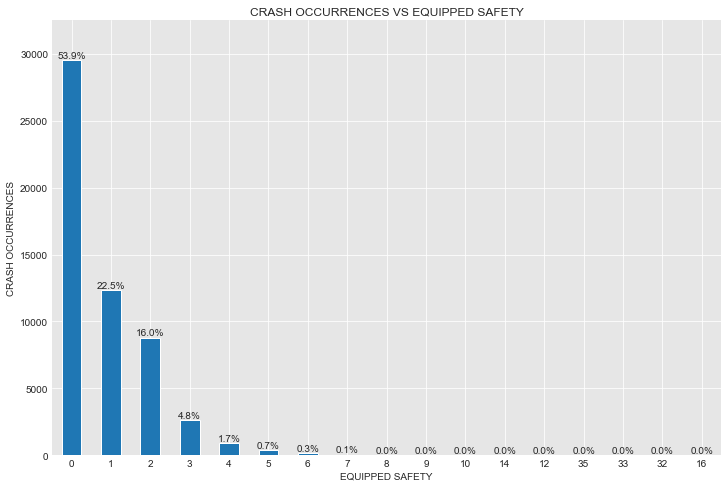

In [34]:
# Crash occurence vs safety equipment plot
equipment_rates=people_agg.SAFETY_EQUIPMENT.value_counts()
equipment_rates.plot(kind='bar', figsize=(12,8))
plt.title('CRASH OCCURRENCES VS EQUIPPED SAFETY')
plt.xlabel('EQUIPPED SAFETY')
plt.ylabel('CRASH OCCURRENCES')
plt.xticks(rotation=0)
plt.ylim(0, equipment_rates.max() * 1.1)
total = equipment_rates.sum()
for i, rate in enumerate(equipment_rates):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [35]:
# Merging DataFrames.
vehicle_people_df=pd.merge(people_agg, vehicle_agg, on='CRASH_RECORD_ID', how='inner')
final_df=pd.merge(crashes, vehicle_people_df, on='CRASH_RECORD_ID', how='inner')

In [36]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54854 entries, 0 to 54853
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CRASH_RECORD_ID       54854 non-null  object 
 1   WEATHER_CONDITION     54854 non-null  object 
 2   LIGHTING_CONDITION    54854 non-null  object 
 3   CRASH_TYPE            54854 non-null  object 
 4   CRASH_HOUR            54854 non-null  int64  
 5   CRASH_MONTH           54854 non-null  int64  
 6   NUM_UNITS             54854 non-null  int64  
 7   ROADWAY_SURFACE_COND  54854 non-null  object 
 8   POSTED_SPEED_LIMIT    54854 non-null  int64  
 9   IS_SEVERE             54854 non-null  bool   
 10  AGE                   54854 non-null  float64
 11  SAFETY_EQUIPMENT      54854 non-null  int64  
 12  OCCUPANT_CNT          54854 non-null  float64
dtypes: bool(1), float64(2), int64(5), object(5)
memory usage: 5.5+ MB


## MODELLING

In [37]:
# Target and feature selection
target = final_df.IS_SEVERE
features = final_df.drop(columns=['CRASH_RECORD_ID', 'IS_SEVERE'], axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

In [39]:
# Data types selection.
X_train_cat=X_train.select_dtypes(exclude=['int64','float64']).copy()
X_train_num=X_train.select_dtypes(include=['int64','float64']).copy()

In [40]:
# Scaling and encoding the train data.
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train_num), index=X_train_num.index, columns=X_train_num.columns)
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe_array = ohe.fit_transform(X_train_cat)
column_names = []
for i, cats in enumerate(ohe.categories_):
    column_names.extend([f"{X_train_cat.columns[i]}_{cat}" for cat in cats[:]])

X_train_ohe = pd.DataFrame(X_train_ohe_array, index=X_train_cat.index, columns=column_names)
X_train_ohe.head()

,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_OTHER_RARE,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,...,LIGHTING_CONDITION_DUSK,LIGHTING_CONDITION_UNKNOWN,CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH,CRASH_TYPE_NO INJURY / DRIVE AWAY,ROADWAY_SURFACE_COND_DRY,ROADWAY_SURFACE_COND_ICE,ROADWAY_SURFACE_COND_OTHER_RARE,ROADWAY_SURFACE_COND_SNOW OR SLUSH,ROADWAY_SURFACE_COND_UNKNOWN,ROADWAY_SURFACE_COND_WET
36739,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
12156,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
16558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
44397,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
46994,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
# Merging columns.
X_train_full=pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_train_full.head()

,CRASH_HOUR,CRASH_MONTH,NUM_UNITS,POSTED_SPEED_LIMIT,AGE,SAFETY_EQUIPMENT,OCCUPANT_CNT,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,...,LIGHTING_CONDITION_DUSK,LIGHTING_CONDITION_UNKNOWN,CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH,CRASH_TYPE_NO INJURY / DRIVE AWAY,ROADWAY_SURFACE_COND_DRY,ROADWAY_SURFACE_COND_ICE,ROADWAY_SURFACE_COND_OTHER_RARE,ROADWAY_SURFACE_COND_SNOW OR SLUSH,ROADWAY_SURFACE_COND_UNKNOWN,ROADWAY_SURFACE_COND_WET
36739,0.155998,-0.811417,-0.081371,0.284961,-1.427904,1.039315,-0.096201,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
12156,-0.561330,0.948609,4.696001,0.284961,1.211448,1.039315,1.498025,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
16558,0.873326,0.948609,-0.081371,0.284961,-0.797611,-0.722292,-0.096201,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
44397,1.411322,-0.811417,-0.081371,0.284961,-1.309724,0.158511,-0.893313,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
46994,-2.354650,-1.398092,-0.081371,-5.093441,-1.309724,-0.722292,-0.893313,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
# Data types selection.
X_test_cat=X_test.select_dtypes(exclude=['int64','float64']).copy()
X_test_num=X_test.select_dtypes(include=['int64','float64']).copy()

In [43]:
# Scaling and encoding the test data.
scaler=StandardScaler()
X_test_scaled=pd.DataFrame(scaler.fit_transform(X_test_num), index=X_test_num.index, columns=X_test_num.columns)
X_test_ohe_array = ohe.fit_transform(X_test_cat)
# Get column names correctly without dropping first category
column_names = []
for i, cats in enumerate(ohe.categories_):
    column_names.extend([f"{X_test_cat.columns[i]}_{cat}" for cat in cats[:]])
X_test_ohe = pd.DataFrame(X_test_ohe_array, index=X_test_cat.index, columns=column_names)
X_test_ohe.head()

,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_OTHER_RARE,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,...,LIGHTING_CONDITION_DUSK,LIGHTING_CONDITION_UNKNOWN,CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH,CRASH_TYPE_NO INJURY / DRIVE AWAY,ROADWAY_SURFACE_COND_DRY,ROADWAY_SURFACE_COND_ICE,ROADWAY_SURFACE_COND_OTHER_RARE,ROADWAY_SURFACE_COND_SNOW OR SLUSH,ROADWAY_SURFACE_COND_UNKNOWN,ROADWAY_SURFACE_COND_WET
3290,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
46998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
21597,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
41169,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Merging columns.
X_test_full=pd.concat([X_test_scaled, X_test_ohe], axis=1)
X_test_full.head()

,CRASH_HOUR,CRASH_MONTH,NUM_UNITS,POSTED_SPEED_LIMIT,AGE,SAFETY_EQUIPMENT,OCCUPANT_CNT,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,...,LIGHTING_CONDITION_DUSK,LIGHTING_CONDITION_UNKNOWN,CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH,CRASH_TYPE_NO INJURY / DRIVE AWAY,ROADWAY_SURFACE_COND_DRY,ROADWAY_SURFACE_COND_ICE,ROADWAY_SURFACE_COND_OTHER_RARE,ROADWAY_SURFACE_COND_SNOW OR SLUSH,ROADWAY_SURFACE_COND_UNKNOWN,ROADWAY_SURFACE_COND_WET
3290,-0.018096,1.534072,-0.078183,0.283610,0.222252,-0.691602,-0.121126,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
46998,1.773776,-1.408858,-0.078183,0.283610,-0.284659,0.142222,-0.121126,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
21597,1.415402,0.356900,-0.078183,-2.428821,-0.001443,-0.691602,-0.947221,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
41169,-1.451594,-0.820272,2.231794,-0.620534,-0.284659,-0.691602,-0.947221,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11545,0.340278,0.945486,-0.078183,0.283610,-1.779394,-0.691602,8.139823,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### RANDOM FOREST CLASSIFIER

In [45]:
# Instantiating a Random Forest Classifier
rf_clf=RandomForestClassifier(class_weight='balanced', random_state=42)
rf_clf.fit(X_train_full, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

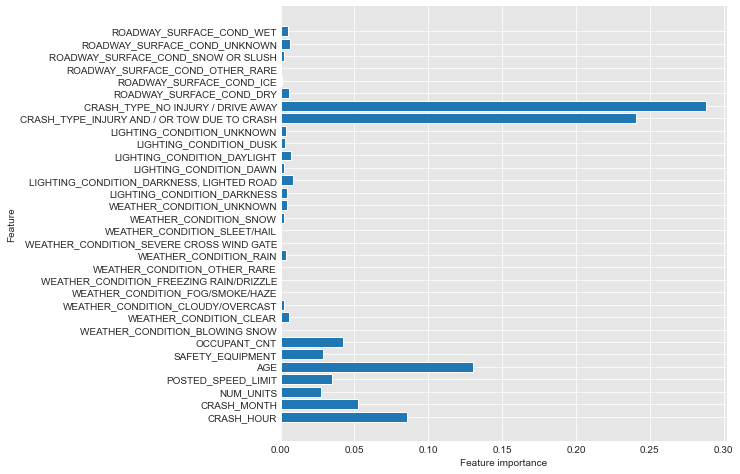

In [46]:
def plot_feature_importances(model):
    n_features = X_train_full.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_full.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rf_clf)

In [47]:
# Test set predictions
pred = rf_clf.predict(X_test_full)
# Classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     16200
        True       0.13      0.01      0.01       257

    accuracy                           0.98     16457
   macro avg       0.56      0.50      0.50     16457
weighted avg       0.97      0.98      0.98     16457



In [48]:
print(rf_clf.score(X_train_full, y_train))
print(rf_clf.score(X_test_full, y_test))

0.9997656066880225
0.9837151364161147


In [49]:
rf_param_grid = {'n_estimators': [10, 30],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 2, 5, 10],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 3, 5]}
rf_grid_search = GridSearchCV(rf_clf, param_grid=rf_param_grid, cv=3, return_train_score=True)
rf_grid_search.fit(X_train_full, y_train)
print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 98.38%
Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}


In [50]:
rf_clf_2=RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=30, class_weight='balanced', random_state=42)
rf_clf_2.fit(X_train_full, y_train)
pred=rf_clf_2.predict(X_test_full)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     16200
        True       0.13      0.01      0.01       257

    accuracy                           0.98     16457
   macro avg       0.56      0.50      0.50     16457
weighted avg       0.97      0.98      0.98     16457



## The recall is so low due to severe class imbalance.

## Now for Synthetic Minority Oversampling technique (SMOTE)

In [51]:
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_full, y_train)

In [52]:
rf = RandomForestClassifier(
    n_estimators=30,
    class_weight='balanced',   
    max_depth=None,             
    min_samples_leaf=1,       
    min_samples_split=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       n_estimators=30, n_jobs=-1, random_state=42)

In [53]:
y_pred_rf = rf.predict(X_test_full)

In [54]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       False       0.99      0.83      0.90     16200
        True       0.06      0.64      0.10       257

    accuracy                           0.83     16457
   macro avg       0.52      0.73      0.50     16457
weighted avg       0.98      0.83      0.89     16457



## XGBoost

In [55]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train_full, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train_full)
test_preds = clf.predict(X_test_full)

print('Training Accuracy: {:.4}%'.format(accuracy_score(y_train, training_preds) * 100))
print('Validation accuracy: {:.4}%'.format(accuracy_score(y_test, test_preds) * 100))
print('Training Recall: {:.4}%'.format(recall_score(y_train, training_preds)))
print('Validation Recall: {:.4}%'.format(recall_score(y_test, test_preds)))

Training Accuracy: 98.66%
Validation accuracy: 98.38%
Training Recall: 0.1436%
Validation Recall: 0.0%


## Very low recall

In [56]:
scale_pos_weight = (
    y_train.value_counts()[0] / y_train.value_counts()[1]
)
model = XGBClassifier(
    n_estimators=400,            
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,                
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    random_state=42
)
model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [57]:
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [5, 10, 20],
    'gamma': [0, 1, 5]
}
grid = GridSearchCV(
    model,
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)
grid.fit(X_train_res, y_train_res)
best_model = grid.best_estimator_

In [58]:
y_pred = best_model.predict(X_test_full)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

       False      1.000     0.725     0.840     16200
        True      0.054     0.996     0.103       257

    accuracy                          0.729     16457
   macro avg      0.527     0.860     0.472     16457
weighted avg      0.985     0.729     0.829     16457



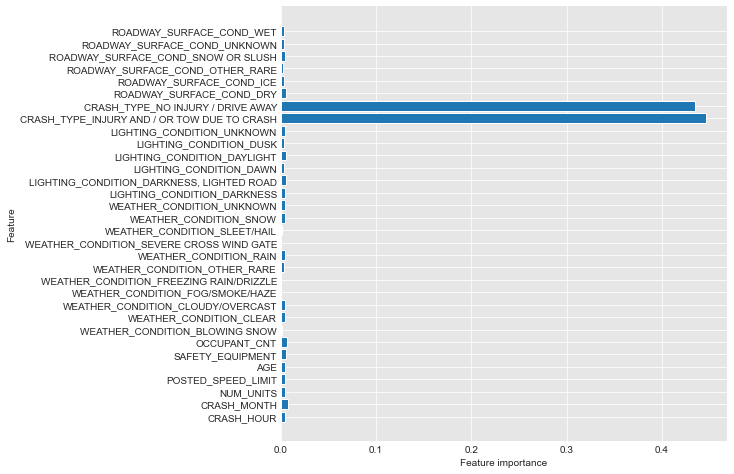

In [59]:
plot_feature_importances(best_model)

## The most important feature in our xgboost model is crash type injury and or tow due to crash.